In [1]:
import pandas as pd
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

In [2]:
data_1 = pd.read_csv('Trip List Edited 12.1.2022-2.1.2023.csv', parse_dates=['Date of Service'], index_col = 'Date of Service')
data_2 = pd.read_csv('Trip List Edited 2.1.2023-4.1.2023.csv', parse_dates=['Date of Service'], index_col = 'Date of Service')
data_3 = pd.read_csv('Trip List Edited 4.1.2023-6.1.2023.csv', parse_dates=['Date of Service'], index_col = 'Date of Service')
data_4 = pd.read_csv('Trip List Edited 8.1.2023-12.21-2023.csv', parse_dates=['Date of Service'], index_col = 'Date of Service')
data_current_cycle = pd.read_csv('Trip List Edited Current.csv', parse_dates=['Date of Service'], index_col = 'Date of Service')

#data = pd.concat([data_1, data_2, data_3, data_4])
data = pd.concat([data_1, data_2, data_3, data_4, data_current_cycle])

data = data.dropna()

# with pd.option_context('display.max_rows', None,):
#     print(data)

data

,Unit,Call Type,Priority,Nature of Call,Location
Date of Service,,,,,
2022-12-01,MEDIC 201,BLS,PRIORITY 2 - IMMEDIATE,Transfer/Interfacility/Palliative Care,JACKSONVILLE
2022-12-01,MEDIC 201,BLS,PRIORITY 3,Psychiatric Problem/Abnormal Behavior/Suicide ...,JACKSONVILLE
2022-12-01,MEDIC 208,BLS,PRIORITY 4,Discharge,BELLAIR-MEADOWBROOK TERRACE
2022-12-01,MEDIC 208,BLS,PRIORITY 4,Discharge,BELLAIR-MEADOWBROOK TERRACE
2022-12-01,MEDIC 201,BLS,PRIORITY 4,Discharge,BELLAIR-MEADOWBROOK TERRACE
...,...,...,...,...,...
2024-01-11,MEDIC 203,BLS,PRIORITY 4,Discharge,JACKSONVILLE
2024-01-11,MEDIC 203,BLS,PRIORITY 4,Discharge,JACKSONVILLE
2024-01-11,MEDIC 201,BLS,PRIORITY 4,Discharge,BELLAIR-MEADOWBROOK TERRACE


In [3]:
#data['Date of Service'] = pd.to_datetime(data['Date of Service'])
#data.set_index('Date of Service')
#data.sort_index()
data['Location'] = data['Location'].str.strip()

# Filtering for Jacksonville location
data_location = data[data['Location'] == 'WAYCROSS']

# Parameters for the model and forecast
# n_test = 14  # Number of days for testing

data_location #Now has only Jacksonville locations

,Unit,Call Type,Priority,Nature of Call,Location
Date of Service,,,,,
2023-08-02,MEDIC 204,ALS,PRIORITY 2 - IMMEDIATE,Transfer/Interfacility/Palliative Care,WAYCROSS
2023-08-12,MEDIC 202,ALS,PRIORITY 1 - EMERGENT,Transfer/Interfacility/Palliative Care,WAYCROSS
2023-08-20,MEDIC 201,ALS,PRIORITY 1 - EMERGENT,Transfer/Interfacility/Palliative Care,WAYCROSS
2023-09-15,MEDIC 201,ALS,PRIORITY 2 - IMMEDIATE,Transfer/Interfacility/Palliative Care,WAYCROSS
2023-09-18,MEDIC 201,ALS,PRIORITY 3,Transfer/Interfacility/Palliative Care,WAYCROSS


In [4]:
#Encode Data
label_encoders = {}
for column in ['Call Type', 'Priority', 'Nature of Call']:
    encoder = LabelEncoder()
    data_location[column] = encoder.fit_transform(data_location[column])
    label_encoders[column] = encoder

#grouped_data = data.groupby(['Date of Service','Location', 'Unit', 'Call Type', 'Priority', 'Nature of Call']).size().reset_index(name='Daily Count')
#grouped_data = grouped_data.sort_values(by='Date of Service')

#Scaling exogenous values
features_to_normalize = ['Call Type', 'Priority', 'Nature of Call']
scaler = MinMaxScaler() #0 Values to represent Unit not being there for that day. 
data_location[features_to_normalize] = scaler.fit_transform(data_location[features_to_normalize]) 
data_location
#grouped_data[features_to_normalize] = scaler.fit_transform(grouped_data[features_to_normalize])
#grouped_data

C:\Users\P3152044\AppData\Local\Temp\ipykernel_7092\3572005536.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_location[column] = encoder.fit_transform(data_location[column])
C:\Users\P3152044\AppData\Local\Temp\ipykernel_7092\3572005536.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_location[column] = encoder.fit_transform(data_location[column])
C:\Users\P3152044\AppData\Local\Temp\ipykernel_7092\3572005536.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,Unit,Call Type,Priority,Nature of Call,Location
Date of Service,,,,,
2023-08-02,MEDIC 204,0.0,0.5,0.0,WAYCROSS
2023-08-12,MEDIC 202,0.0,0.0,0.0,WAYCROSS
2023-08-20,MEDIC 201,0.0,0.0,0.0,WAYCROSS
2023-09-15,MEDIC 201,0.0,0.5,0.0,WAYCROSS
2023-09-18,MEDIC 201,0.0,1.0,0.0,WAYCROSS


The cell below uses a grid search to pick the best parameters for SARIMAX

In [5]:
# Define the parameter space for SARIMAX
p = d = q = range(0, 3)  # Example ranges for ARIMA orders
P = D = Q = range(0, 3)
s = [7, 14, 30]  #Testing for Weekly, Bi-Weely, and Monthly Seasonality

# Random Grid Search across all units
parameters = list(itertools.product(p, d, q, P, D, Q, s))
pdq_combinations = random.sample(parameters, min(len(parameters), 0))  # Randomly sample combinations

In [6]:
pdq_combinations

[]

In [7]:
#pdq_combinations = [(1, 0, 2, 2, 1, 1, 7), ] #Testing specific parameters. 
pdq_combinations.extend(((0, 1, 2, 0, 2, 1, 30), (0, 2, 2, 1, 0, 0, 7), (1, 0, 0, 2, 1, 0, 7), (1, 0, 2, 0, 0, 2, 7), 
                        (1, 2, 2, 0, 0, 0, 30)))
pdq_combinations

[(0, 1, 2, 0, 2, 1, 30),
 (0, 2, 2, 1, 0, 0, 7),
 (1, 0, 0, 2, 1, 0, 7),
 (1, 0, 2, 0, 0, 2, 7),
 (1, 2, 2, 0, 0, 0, 30)]

Section: Used for testing Code

In [8]:
# # Apply best parameters for each unit to test
# unit_IDs = sorted(data_location['Unit'].unique())

# #Splitting training and testing by date
# split_date = pd.Timestamp('2023-11-30')

# start_date = data_location.index.min()
# end_date = data_location.index.max()
# date_range = pd.date_range(start= start_date, end= end_date, freq = 'D')
# exog_data = data_location[['Call Type', 'Priority', 'Nature of Call']].groupby(data_location.index).mean().reindex(
#                                                                                                             date_range, 
#                                                                                                             fill_value = 0)

# for unit_ID in unit_IDs:
#     print(f"Processing Medic Unit: {unit_ID}")

#     unit_data_grouped = data_location[data_location['Unit'] == unit_ID].resample('D').count().reindex(date_range, 
#                                                                                                       fill_value = 0)
#     unit_data_grouped = unit_data_grouped.drop('Location', axis = 1)
#     #print(unit_data_grouped['Unit'][0])

#     for i in range(len(unit_data_grouped)):
#         if unit_data_grouped['Unit'][i] > 0:
#             unit_data_grouped['Call Type'][i] = exog_data['Call Type'][i]
#             unit_data_grouped['Priority'][i] = exog_data['Priority'][i]
#             unit_data_grouped['Nature of Call'][i] = exog_data['Nature of Call'][i]
            
#             data_unit = unit_data_grouped['Unit']
#             exog_unit = unit_data_grouped[['Call Type', 'Priority', 'Nature of Call']]
            
#     #print(exog_unit)
    
#     #train_end = pd.to_datetime("11/30/2023")
#     train = data_unit[data_unit.index < split_date]
#     test = data_unit[data_unit.index >= split_date]

#     train_exog = exog_unit[exog_unit.index < split_date]
#     test_exog = exog_unit[exog_unit.index >= split_date]
    
#     print(data_unit)

Section: Code Testing - End

In [9]:
def sarimax_grid_search(data_location, pdq_combinations): #Aggregated order and seasonal order. 
#     best_aic = float("inf")
#     best_configuration = None
#     best_model = None
    
    # Apply best parameters for each unit to test
    unit_IDs = sorted(data_location['Unit'].unique())
    
    #Used for training/test split further below. 
    split_date = pd.Timestamp('2023-8-30')
    
    #Preparing exogenous values
    start_date = data_location.index.min()
    end_date = data_location.index.max()
    date_range = pd.date_range(start= start_date, end= end_date, freq = 'D')
    exog_data = data_location[['Call Type', 'Priority', 'Nature of Call']].groupby(data_location.index).mean().reindex(
                                                                                                                date_range, 
                                                                                                                fill_value = 0)
    # Initialize a dictionary to store best_configuration
    unit_results={}
    
    for unit_ID in unit_IDs:
        best_aic = float("inf")
        best_configuration = None
        best_model = None
        
        print(f"Processing Medic Unit: {unit_ID}")
        
        #Using date_range from preparing exogenous values
        unit_data_grouped = data_location[data_location['Unit'] == unit_ID].resample('D').count().reindex(date_range, 
                                                                                                          fill_value = 0)
        unit_data_grouped = unit_data_grouped.drop('Location', axis = 1)
        #print(unit_data_grouped['Unit'][0])

        for i in range(len(unit_data_grouped)):
            if unit_data_grouped['Unit'][i] > 0:
                unit_data_grouped['Call Type'][i] = exog_data['Call Type'][i]
                unit_data_grouped['Priority'][i] = exog_data['Priority'][i]
                unit_data_grouped['Nature of Call'][i] = exog_data['Nature of Call'][i]
        
        data_unit = unit_data_grouped['Unit']
        exog_unit = unit_data_grouped[['Call Type', 'Priority', 'Nature of Call']]
        
        #train_end = pd.to_datetime("11/30/2023")
        train = data_unit[data_unit.index < split_date]
        test = data_unit[data_unit.index >= split_date]
        
        train_exog = exog_unit[exog_unit.index < split_date]
        test_exog = exog_unit[exog_unit.index >= split_date]
        
        #For lesser computers.
        for pdq in pdq_combinations:
            try:
                model = SARIMAX(train, order=pdq[:3], seasonal_order=pdq[3:], exog = train_exog, 
                                enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit(disp=False)

                if model_fit.aic < best_aic: 
                    best_aic = model_fit.aic
                    best_configuration = pdq
                    best_model = model_fit

            except Exception as e: 
                print(f'Exception: {e}')
                continue
        
        #Storing best_configuration
        unit_results[unit_ID] = {'best_configuration' : best_configuration}
        
        if best_configuration is None:
            raise ValueError("No suitable model parameters found for aggregate data")
            
        #Predicting the rest of the forecast to compare to test data. Steps has to be the remaining days to predict. 
        predictions = best_model.forecast(steps=len(test), exog = test_exog)
#         predictions = best_model.get_forecast(steps=len(test), exog = test_exog)
#         forecast_values = predictions.predict_mean

        # Performance Metrics
        mse = mean_squared_error(test, predictions)
        mae = mean_absolute_error(test, predictions)
        rmse = np.sqrt(mse)
        print(f'Unit {unit_ID} - Best SARIMAX: {best_configuration} - MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

        # Plotting Forecast vs Actual
        plt.figure(figsize=(10, 6))
        plt.plot(test, label='Actual')
        plt.plot(predictions, label='Forecast', color='red')
        plt.title(f'SARIMAX Model Forecast vs Actual for Unit {unit_ID}')
        plt.xlabel('Date')
        plt.ylabel('Unit')
        plt.legend()
        plt.show()
            
    return best_aic, best_configuration, best_model, unit_results

C:\Users\P3152044\AppData\Local\Temp\ipykernel_7092\3999323522.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit_data_grouped['Nature of Call'][i] = exog_data['Nature of Call'][i]
C:\Users\P3152044\AppData\Local\Temp\ipykernel_7092\3999323522.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit_data_grouped['Call Type'][i] = exog_data['Call Type'][i]
C:\Users\P3152044\AppData\Local\Temp\ipykernel_7092\3999323522.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

Processing Medic Unit: MEDIC 201


C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Unit MEDIC 201 - Best SARIMAX: (1, 0, 0, 2, 1, 0, 7) - MSE: 0.20000046217009557, MAE: 0.20000030811296193, RMSE: 0.44721411222153484


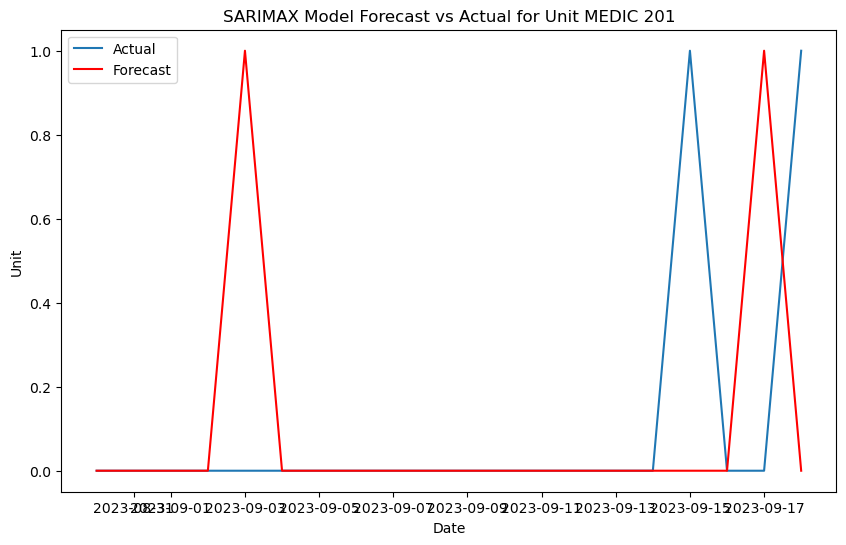

Processing Medic Unit: MEDIC 202


C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observation

Unit MEDIC 202 - Best SARIMAX: (1, 0, 2, 0, 0, 2, 7) - MSE: 2.758770282057586e-61, MAE: 1.649123681384487e-31, RMSE: 5.252399720182753e-31


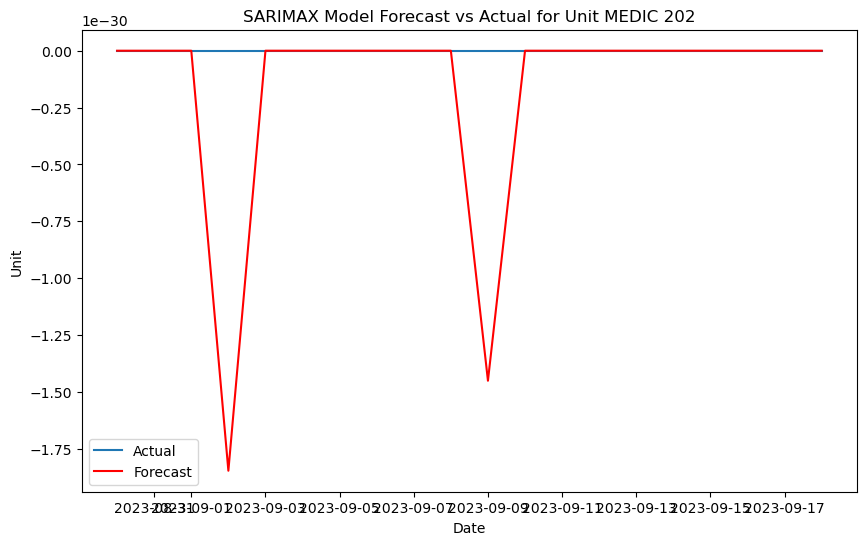

Processing Medic Unit: MEDIC 204


C:\Users\P3152044\AppData\Local\Temp\ipykernel_7092\3999323522.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit_data_grouped['Nature of Call'][i] = exog_data['Nature of Call'][i]
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:

Unit MEDIC 204 - Best SARIMAX: (1, 2, 2, 0, 0, 0, 30) - MSE: 0.0, MAE: 0.0, RMSE: 0.0


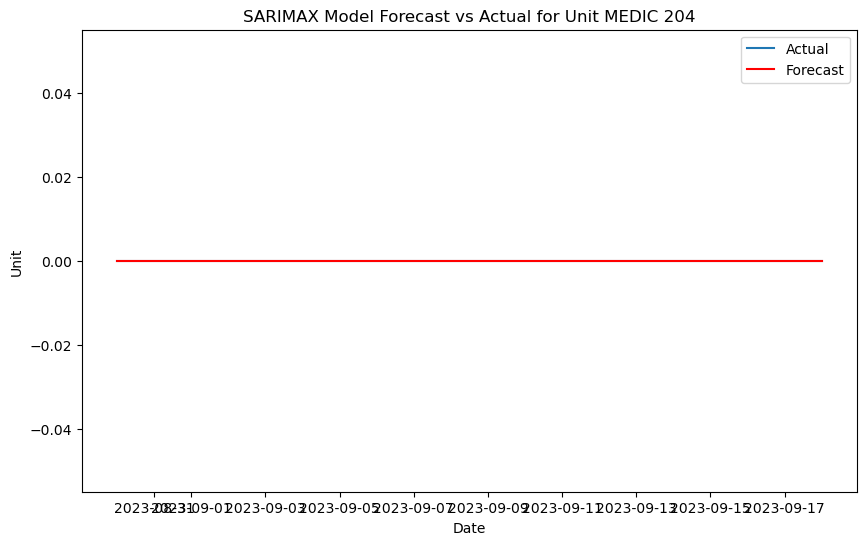

In [10]:
# #Running Grid Search
# #SARIMAX can internally difference with value (d). We manually difference (d=1) just to check stationarity. 
# #Now we will let SARIMAX integrate difference by setting d=1 manually on the ORIGINAL dataset. 

#ts_data = df['Actual Trips']
#ts_data = train['Unit']

ts_data = data_location

# exog_train = train[['Call Type', 'Priority', 'Nature of Call']]
# exog_test = test[['Call Type', 'Priority', 'Nature of Call']]

# #For lesser PC
best_aic, best_configuration, best_model, unit_results = sarimax_grid_search(ts_data, pdq_combinations)

#print(f"Best SARIMAX parameters: {best_configuration} with AIC: {best_aic}")

In [11]:
best_configuration #You can interupt cell above to get the current best_params value without having to finish all the calculations. 

(1, 2, 2, 0, 0, 0, 30)

In [12]:
best_config = unit_results['MEDIC 201'].values()
results = list(best_config)
results[0]

(1, 0, 0, 2, 1, 0, 7)

Everything below is to generate future values. (Needs to be reworked.) 

In [13]:
#The best parameters for all Units combined; Unit MEDIC 1 usually has highest RSME so minimizing this
    #Best SARIMAX: (0, 0, 0, 2, 0, 1, 7) - MSE: 3.477645430848429, MAE: 1.3565603776833444, RMSE: 1.8648446130571

unique_locations = data['Location'].unique()
print("Unique Locations:", unique_locations)

Unique Locations: ['JACKSONVILLE' 'BELLAIR-MEADOWBROOK TERRACE' 'FRUIT COVE' 'MIDDLEBURG'
 'SAINT JOHNS' 'JACKSONVILLE BEACH' 'ORANGE PARK' 'FERNANDINA BEACH'
 'FLEMING ISLAND' 'LAKE BUTLER' 'SAINT AUGUSTINE' 'ATLANTIC BEACH'
 'MACCLENNY' 'DAYTONA' 'GAINESVILLE' 'YULEE' 'WORLD GOLF VILLAGE'
 'PALM COAST' 'PALATKA' 'LAKE CITY' 'PONTE VEDRA BEACH' 'WAYCROSS'
 'KISSIMMEE' 'ST  AUGUSTINE' 'PALM VALLEY']


In [14]:
# Correct the filtering condition based on the actual string in your dataset
data_location = data[data['Location'] == 'WAYCROSS']

# Get unique 'Medic Units' 
unit_IDs = data_location['Unit'].unique()
unit_IDs = sorted(unit_IDs)
print("Unique Units in Waycross:", unit_IDs)

Unique Units in Waycross: ['MEDIC 201', 'MEDIC 202', 'MEDIC 204']


In [15]:
print("Unique Vehicle IDs in Waycross:", unit_IDs)

#Preparing exogenous values
#Using date_range from preparing exogenous values
start_date = data_location.index.min()
end_date = data_location.index.max()
date_range = pd.date_range(start= start_date, end= end_date, freq = 'D')

models = {} #Fitting model for all units individually.
for unit_ID in unit_IDs:
    print(f"Processing Call Type: {unit_ID}")

    # Aggregate data by day for each 'Unit'
    ts = data_location[data_location['Unit'] == unit_ID].resample('D').count().reindex(date_range, fill_value = 0)
    ts = ts.drop('Location', axis = 1)
    ts_data = ts['Unit']
    
    #print(f"Sample Data for {unit_ID}:\n", ts.head())  # Print sample data
    #Retrieve best_configuration for current unit
    results = unit_results[unit_ID].values()
    results = list(results)
    best_configuration = results[0]
    
    # Check if time series is not empty
    if not ts.empty:
        model = SARIMAX(ts_data, order=best_configuration[:3], seasonal_order=best_configuration[3:], #exog = train_exog, #Implementing later
                       enforce_stationarity=False, enforce_invertibility=False) 
        models[unit_ID] = model.fit(disp=True)
    else:
        print(f"No data available for Call Type: {unit_ID}")

Unique Vehicle IDs in Waycross: ['MEDIC 201', 'MEDIC 202', 'MEDIC 204']
Processing Call Type: MEDIC 201
Processing Call Type: MEDIC 202
Processing Call Type: MEDIC 204


C:\Users\P3152044\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
forecasts = {}
steps = 14
for unit_ID, model in models.items():
    forecasts[unit_ID] = model.forecast(steps)  # Forecasting for the next day

In [17]:
from datetime import timedelta

# Determine the date for the forecast
# Assuming you are forecasting for the next day after the last date in your data
last_date = data.index.max()
start_forecast_date = last_date + timedelta(days=1)

# Initialize a dictionary to store forecasts for each date
date_forecasts = {start_forecast_date + timedelta(days=i): [] for i in range(steps)}

# Generate and store forecasts for each call type and each date
for unit_ID in unit_IDs:
    model = models.get(unit_ID)
    if model:
        forecast_values = model.forecast(steps=steps)
        forecast_values = abs(forecast_values)
        for i in range(steps):
            forecast_date = start_forecast_date + timedelta(days=i)
            # Append the forecast string for each call type and date
            #date_forecasts[forecast_date].append(f"{forecast_values[i]:.0f} calls of type '{vehicle_ID}'")
            #date_forecasts[forecast_date].append(f"{vehicle_ID}: {forecast_values[i]:.0f}")
            date_forecasts[forecast_date].append(f"{unit_ID}: {forecast_values[i]:.0f}")
    else:
        # Handle case where there is no model for a call type
        for date in date_forecasts:
            date_forecasts[date].append(f"0 calls for unit '{unit_ID}'")

# Print the combined forecast message for each date
for date, forecasts in date_forecasts.items():
    forecast_message = " \n".join(forecasts)
    print(f"There will be: \n{forecast_message}\nin the location of Waycross {date.strftime('%Y-%m-%d')}")

There will be: 
MEDIC 201: 0 
MEDIC 202: 0 
MEDIC 204: 0
in the location of Waycross 2024-01-12
There will be: 
MEDIC 201: 0 
MEDIC 202: 0 
MEDIC 204: 0
in the location of Waycross 2024-01-13
There will be: 
MEDIC 201: 0 
MEDIC 202: 0 
MEDIC 204: 0
in the location of Waycross 2024-01-14
There will be: 
MEDIC 201: 0 
MEDIC 202: 0 
MEDIC 204: 0
in the location of Waycross 2024-01-15
There will be: 
MEDIC 201: 0 
MEDIC 202: 0 
MEDIC 204: 0
in the location of Waycross 2024-01-16
There will be: 
MEDIC 201: 0 
MEDIC 202: 0 
MEDIC 204: 0
in the location of Waycross 2024-01-17
There will be: 
MEDIC 201: 0 
MEDIC 202: 0 
MEDIC 204: 0
in the location of Waycross 2024-01-18
There will be: 
MEDIC 201: 0 
MEDIC 202: 0 
MEDIC 204: 0
in the location of Waycross 2024-01-19
There will be: 
MEDIC 201: 0 
MEDIC 202: 0 
MEDIC 204: 0
in the location of Waycross 2024-01-20
There will be: 
MEDIC 201: 0 
MEDIC 202: 0 
MEDIC 204: 0
in the location of Waycross 2024-01-21
There will be: 
MEDIC 201: 0 
MEDIC 202:

In [18]:
#Creating an empty DataFrame with specified columns
#forecast_results_df = pd.DataFrame(columns=['Date of Service', 'Call Type & Volume', 'Location'])

# Initialize a list to store forecast data for DataFrame
forecast_data = []

#Generate forecast data suitable for DataFrame
for date, forecasts in date_forecasts.items():
    #forecast_message = " and ".join(forecasts)
    forecast_message = ' , '.join(forecasts)
    forecast_data.append({
        "Date of Service": date.strftime('%A: %m-%d-%Y'),
        "Unit": forecast_message,
        "Location": "Waycross"  # or dynamically set location if needed
    })
    
# Create a DataFrame
forecast_df = pd.DataFrame(forecast_data)
forecast_df

,Date of Service,Unit,Location
0,Friday: 01-12-2024,"MEDIC 201: 0 , MEDIC 202: 0 , MEDIC 204: 0",Waycross
1,Saturday: 01-13-2024,"MEDIC 201: 0 , MEDIC 202: 0 , MEDIC 204: 0",Waycross
2,Sunday: 01-14-2024,"MEDIC 201: 0 , MEDIC 202: 0 , MEDIC 204: 0",Waycross
3,Monday: 01-15-2024,"MEDIC 201: 0 , MEDIC 202: 0 , MEDIC 204: 0",Waycross
4,Tuesday: 01-16-2024,"MEDIC 201: 0 , MEDIC 202: 0 , MEDIC 204: 0",Waycross
5,Wednesday: 01-17-2024,"MEDIC 201: 0 , MEDIC 202: 0 , MEDIC 204: 0",Waycross
6,Thursday: 01-18-2024,"MEDIC 201: 0 , MEDIC 202: 0 , MEDIC 204: 0",Waycross
7,Friday: 01-19-2024,"MEDIC 201: 0 , MEDIC 202: 0 , MEDIC 204: 0",Waycross
8,Saturday: 01-20-2024,"MEDIC 201: 0 , MEDIC 202: 0 , MEDIC 204: 0",Waycross
9,Sunday: 01-21-2024,"MEDIC 201: 0 , MEDIC 202: 0 , MEDIC 204: 0",Waycross


In [19]:
# Define the output file path
output_file_path = 'Model Forecast Results.csv'

# Saving the DataFrame to a CSV file
try:
    forecast_df.to_csv(output_file_path, mode='a', index=False, header=False)
    success = True
except Exception as e:
    success = False
    error_message = str(e)

# Returning the path if successful, else the error message
output_file_path if success else error_message

'Model Forecast Results.csv'